In [1]:
import datetime
import itertools
import requests
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import json 
import time

In [5]:
shoal_waller_gages = ['121', '248', '267', '2400', '2410', '2510', '2520', '3000', '3120', '3130']

# Define time period
startdate = '20220822'
enddate = '20220824'

In [ ]:
variable = 'flow'

startdate_string = format(pd.to_datetime(startdate, format = '%Y%m%d'), '%m-%d-%Y')
enddate_string = format(pd.to_datetime(enddate, format = '%Y%m%d'), '%m-%d-%Y')

for i in shoal_waller_gages: 
    site_id = i

    url = 'https://hydromet.lcra.org/api/CoaHistoricalData/GetDataBySite/' + site_id + '/flow/' + startdate_string + '/' + enddate_string + '/' 
    print(url)
    local_filename = '../../densifimcation_shared/data/gage_data_fews/fews_' + site_id + '_' + startdate + '.json'

    try:
        response = requests.get(url, stream=True)
        response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)

        with open(local_filename, 'wb') as f:
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"File '{local_filename}' downloaded successfully.")

    except requests.exceptions.RequestException as e:
        print(f"Error downloading file: {e}")
    
    time.sleep(20)

https://hydromet.lcra.org/api/CoaHistoricalData/GetDataBySite/121/flow/08-22-2022/08-24-2022/
File '../../densifimcation_shared/data/gage_data_fews/fews_121_20220822.json' downloaded successfully.
https://hydromet.lcra.org/api/CoaHistoricalData/GetDataBySite/248/flow/08-22-2022/08-24-2022/
File '../../densifimcation_shared/data/gage_data_fews/fews_248_20220822.json' downloaded successfully.
https://hydromet.lcra.org/api/CoaHistoricalData/GetDataBySite/267/flow/08-22-2022/08-24-2022/
File '../../densifimcation_shared/data/gage_data_fews/fews_267_20220822.json' downloaded successfully.
https://hydromet.lcra.org/api/CoaHistoricalData/GetDataBySite/2400/flow/08-22-2022/08-24-2022/
File '../../densifimcation_shared/data/gage_data_fews/fews_2400_20220822.json' downloaded successfully.
https://hydromet.lcra.org/api/CoaHistoricalData/GetDataBySite/2410/flow/08-22-2022/08-24-2022/
File '../../densifimcation_shared/data/gage_data_fews/fews_2410_20220822.json' downloaded successfully.
https://hyd

In [ ]:
with open(local_filename) as f:
    fews = json.load(f)
# print(fews)
metadata = {
    'siteId': fews.get('siteId'),
    'siteNumber': fews.get('siteNumber'),
    'siteName': fews.get('siteName'),
    'isHourly': fews.get('isHourly'),
    'isDaily': fews.get('isDaily'),
    'value1Type': fews.get('value1Type'),
    'value2Type': fews.get('value2Type')
}
print(metadata)
df = pd.DataFrame(fews['records'])
df.rename(columns = {'value1':'stage'}, inplace = True)
print(df)

{'siteId': 3130, 'siteNumber': 3130, 'siteName': 'Waller Creek at Hemphill Park', 'isHourly': False, 'isDaily': False, 'value1Type': 'Stage', 'value2Type': 'Flow'}
                 dateTime  stage
0    2022-08-25T04:45:10Z   0.22
1    2022-08-25T04:30:09Z   0.22
2    2022-08-25T04:15:09Z   0.22
3    2022-08-25T04:00:10Z   0.22
4    2022-08-25T03:45:10Z   0.22
..                    ...    ...
282  2022-08-22T06:15:10Z   0.16
283  2022-08-22T06:00:12Z   0.16
284  2022-08-22T05:45:10Z   0.16
285  2022-08-22T05:15:12Z   0.15
286  2022-08-22T05:00:13Z   0.14

[287 rows x 2 columns]


In [6]:
stagelist = []
empty = []
gages_with_data = []
for i in shoal_waller_gages: 
    print(i)
    local_filename = '../../densifimcation_shared/data/gage_data_fews/fews_' + i + '_' + startdate + '.json'
    with open(local_filename) as f:
        fews = json.load(f)
    df = pd.DataFrame(fews['records'])
    if len(df) >= 1: 
        metadata = {
            'siteId': fews.get('siteId'),
            'siteNumber': fews.get('siteNumber'),
            'siteName': fews.get('siteName'),
            'isHourly': fews.get('isHourly'),
            'isDaily': fews.get('isDaily'),
            'value1Type': fews.get('value1Type'),
            'value2Type': fews.get('value2Type')
        }
        # print(metadata)
        df.rename(columns = {'value1':'stage__'+i, 'value2':'flow__'+i}, inplace = True)
        df.reset_index(inplace = True, drop = True)
        df['dateTime'] = (pd.to_datetime(df['dateTime'], format = '%Y-%m-%dT%H:%M:%SZ')).dt.floor('min')
        df = df.set_index('dateTime')
        
        if i == shoal_waller_gages[0]:
            dfstart = df
        else:
            dfstart = pd.merge(dfstart, df, on = 'dateTime', how = 'outer')
        stagelist.append(df)
        gages_with_data.append(i)
    else: 
        print("No Data!!!")
        empty.append(i)

print(gages_with_data)

121
248
267
2400
2410
2510
2520
3000
No Data!!!
3120
No Data!!!
3130
['121', '248', '267', '2400', '2410', '2510', '2520', '3130']


338


Text(0, 0.5, 'Flow (cfs)')

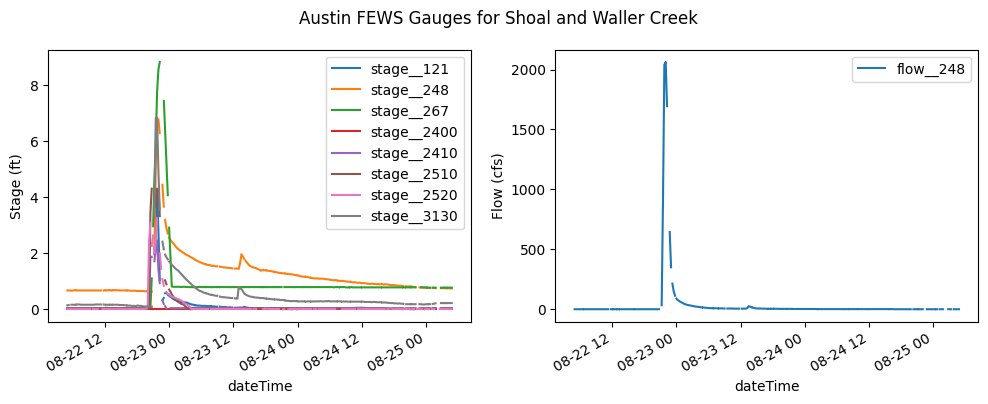

In [7]:
print(len(dfstart))
# print(dfstart)
fig, (ax, ax1) = plt.subplots(1,2, figsize = (12,4))
plt.suptitle('Austin FEWS Gauges for Shoal and Waller Creek')
dfstart.drop('flow__248', axis = 1).plot(ax = ax)
ax.set_ylabel('Stage (ft)')
dfstart.loc[:,'flow__248'].plot(ax = ax1, legend = True)
ax1.set_ylabel('Flow (cfs)')


In [ ]:
import math

dfstart
dfstart['stage__121']
for i in dfstart.columns: 
    dfstart.columns

Index(['stage__121', 'stage__248', 'flow__248', 'stage__267', 'stage__2400',
       'stage__2410', 'stage__2510', 'stage__2520', 'stage__3130'],
      dtype='object')

In [9]:
fewsLU = pd.read_csv('../../DensiFIMcation/data/FEWS_shoal_waller_NWM_Den_SJoin.csv')
fewsLU = fewsLU[['FEWS_ID', 'feature_id', 'HydroID']]
fewsLU['FEWS_ID'] = fewsLU['FEWS_ID'].astype(int).astype(str)
fewsLU['HydroID'] = fewsLU['HydroID'].astype(int).astype(str)
fewsLU['feature_id'] = fewsLU['feature_id'].astype(int).astype(str)
print(fewsLU.head())

  FEWS_ID feature_id HydroID
0     121    5781313    3650
1     248    5781313    3673
2     267    5781223    3620
3    2400    5781703    3679
4    2410    5781221    3635


In [10]:
# Pull in Rating Curves 
nwm_rc = pd.read_csv('../../DensiFIMcation/data/rating_curves_travis_county_NWM.csv')
nwm_rc['Q'] = nwm_rc['discharge_'] * 35.314684921034 # convert to cfs
nwm_rc['H'] = nwm_rc['stage_m'] * 3.28084 # convert to ft 
nwm_rc['feature_id'] = nwm_rc['feature_id'].astype(int).astype(str)
den_rc = pd.read_csv('../../DensiFIMcation/data/rating_curves_shoal_waller_densified.csv')
den_rc['GridID'] = den_rc['GridID'].astype(int).astype(str)

print(pd.merge(fewsLU['feature_id'], nwm_rc['feature_id'], on = 'feature_id', how = 'inner').feature_id.unique())
print(len(nwm_rc.feature_id.unique()))

['5781313' '5781223' '5781703' '5781221']
756


In [11]:
# Step 1: Melt the wide dataframe to long format
measured_long = measured_stage.reset_index().melt(id_vars='index', var_name='reach_id', value_name='measured_H')
measured_long.rename(columns={'index': 'datetime'}, inplace=True)

# Step 2: Prepare sorted rating curves
rc_grouped = {
    rid: group.sort_values('H') for rid, group in rating_curve.groupby('reach_id')
}

# Step 3: Interpolation function (no extrapolation)
def interpolate_q(row, rc_grouped):
    reach_id = row['reach_id']
    h = row['measured_H']
    
    if reach_id not in rc_grouped or pd.isna(h):
        return np.nan

    rc = rc_grouped[reach_id]
    h_vals = rc['H'].values
    q_vals = rc['Q'].values
    
    if h < h_vals[0] or h > h_vals[-1]:
        return np.nan
    
    return np.interp(h, h_vals, q_vals)

# Step 4: Apply interpolation
measured_long['interpolated_Q'] = measured_long.apply(
    lambda row: interpolate_q(row, rc_grouped), axis=1
)

# Step 5: Pivot back to original format
interpolated_Q_wide = measured_long.pivot(index='datetime', columns='reach_id', values='interpolated_Q')

# Optional: match column order to original
interpolated_Q_wide = interpolated_Q_wide[measured_stage.columns]

print(interpolated_Q_wide)

NameError: name 'measured_stage' is not defined

In [ ]:
nwm_rc.query('feature_id == "5781313" and H <')

,HydroID,HIndex,stage_m,discharge_,feature_id,HUC,Travis,Q,H
40070,25051084,2.0,0.3048,15,5781313,12090205,1,5.297203e+02,1.000000
40071,25051084,3.0,0.6096,54,5781313,12090205,1,1.906993e+03,2.000000
40072,25051084,4.0,0.9144,117,5781313,12090205,1,4.131818e+03,3.000000
40073,25051084,5.0,1.2192,200,5781313,12090205,1,7.062937e+03,4.000000
40074,25051084,6.0,1.5240,366,5781313,12090205,1,1.292517e+04,5.000000
...,...,...,...,...,...,...,...,...,...
40235,25051091,30.0,8.8392,22672,5781313,12090205,1,8.006545e+05,29.000001
40236,25051091,31.0,9.1440,26125,5781313,12090205,1,9.225961e+05,30.000001
40237,25051091,32.0,9.4488,30032,5781313,12090205,1,1.060571e+06,31.000001
40238,25051091,33.0,9.7536,34274,5781313,12090205,1,1.210376e+06,32.000001


    HydroID  HIndex  stage_m  discharge_ feature_id       HUC  Travis  \
0  24820253     3.0   0.6096          61    5671187  12070205       1   
1  24820253     4.0   0.9144         131    5671187  12070205       1   
2  24820253     5.0   1.2192         223    5671187  12070205       1   
3  24820253     6.0   1.5240         332    5671187  12070205       1   
4  24820253     7.0   1.8288         430    5671187  12070205       1   

              Q    H  
0   2154.195780  2.0  
1   4626.223725  3.0  
2   7875.174737  4.0  
3  11724.475394  5.0  
4  15185.314516  6.0  
756


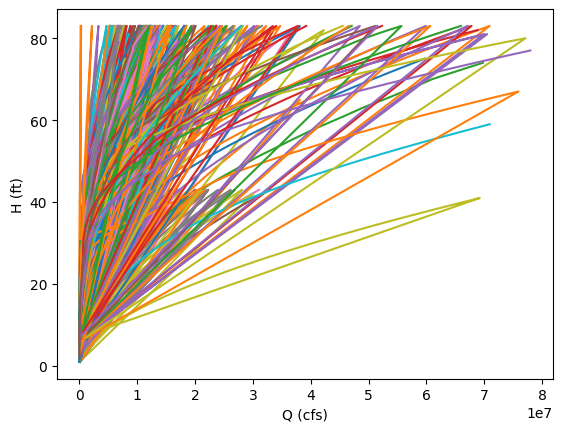

In [ ]:
print(nwm_rc.head())
print(len(nwm_rc.feature_id.unique()))
nwm_rc_group = (nwm_rc.groupby('feature_id'))
# print(nwm_rc[nwm_rc['RiverID' == 3578]])
fig, ax = plt.subplots()
for name, group in nwm_rc_group: 
    # print(name)
    ax.plot(group.Q, group.H, label = str(name))
    ax.set_xlabel('Q (cfs)')
    ax.set_ylabel('H (ft)')

    if str(name) in fewsLU['feature_id'].unique():
        print('Match')
# plt.legend()

   StreamID  GridID    Length_m    H           B         R            A  \
0      3578    3578  164.298865  0.0    9.317384 -0.000297    -0.002848   
1      3578    3578  164.298865  1.0  132.551847  0.423239    56.485059   
2      3578    3578  164.298865  2.0  316.011504  0.914105   290.893555   
3      3578    3578  164.298865  3.0  454.866505  1.478903   678.342977   
4      3578    3578  164.298865  4.0  545.872473  2.144194  1181.986219   

            P  HIndex            Q  ORIG_FID  RiverID  
0    9.577340       0     0.000000         1     3578  
1  133.459130       1    40.723245       136     3578  
2  318.227669       2   350.415626       271     3578  
3  458.679867       3  1126.145126       406     3578  
4  551.249728       4  2513.662820       541     3578  
135


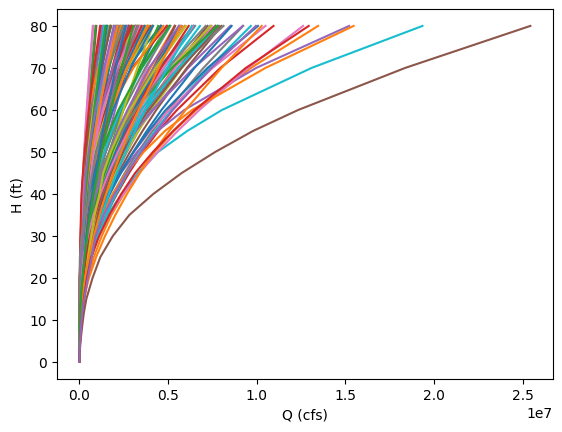

In [ ]:
print(den_rc.head())
print(len(den_rc.HydroID.unique()))
den_rc_group = (den_rc.groupby('HydroID'))
# print(den_rc[den_rc['RiverID' == 3578]])
fig, ax = plt.subplots()
for name, group in den_rc_group: 
    # print(name)
    ax.plot(group.Q, group.H, label = str(name))
    ax.set_xlabel('Q (cfs)')
    ax.set_ylabel('H (ft)')

    if name in fewsLU['HydroID']:
        print('Match')
# plt.legend()

In [ ]:
temp = dfstart.loc[:,'stage__121']


dateTime
2022-08-22 05:00:00    0.02
2022-08-22 05:15:00    0.02
2022-08-22 05:30:00    0.02
2022-08-22 05:45:00    0.02
2022-08-22 06:00:00    0.02
                       ... 
2022-08-25 03:46:00     NaN
2022-08-25 04:00:00    0.03
2022-08-25 04:15:00    0.03
2022-08-25 04:30:00    0.03
2022-08-25 04:45:00    0.03
Name: stage__121, Length: 338, dtype: float64

In [102]:
# print(stagelist)
df_fews = pd.DataFrame(pd.concat(stagelist))
# df_fews.reset_index(inplace = True)
# print(df_fews.loc[0, 'dateTime'])
# print(datetime.datetime.strptime(df_fews.dateTime[0], '%Y-%m-%dT%H:%M:%SZ'))
# df_fews['dateTime'] = (pd.to_datetime(df_fews['dateTime'], format = '%Y-%m-%dT%H:%M:%SZ')).dt.floor('T')
print(df_fews)
print(len(df_fews.dateTime.unique()))
df_fews.to_csv('../../densifimcation_shared/data/gage_data_fews/combined_fews.csv')


               dateTime  stage__121  stage__248  flow__248  stage__267  \
0   2022-08-25 04:45:00        0.03         NaN        NaN         NaN   
1   2022-08-25 04:30:00        0.03         NaN        NaN         NaN   
2   2022-08-25 04:15:00        0.03         NaN        NaN         NaN   
3   2022-08-25 04:00:00        0.03         NaN        NaN         NaN   
4   2022-08-25 03:45:00        0.03         NaN        NaN         NaN   
..                  ...         ...         ...        ...         ...   
282 2022-08-22 06:15:00         NaN         NaN        NaN         NaN   
283 2022-08-22 06:00:00         NaN         NaN        NaN         NaN   
284 2022-08-22 05:45:00         NaN         NaN        NaN         NaN   
285 2022-08-22 05:15:00         NaN         NaN        NaN         NaN   
286 2022-08-22 05:00:00         NaN         NaN        NaN         NaN   

     stage__2400  stage__2410  stage__2510  stage__2520  stage__3130  
0            NaN          NaN          N